# *Init*

In [1]:
#@title Imports

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
from sklearn.model_selection import train_test_split

In [2]:
# #@title Mount Data (For Google Colab)
# # Mount data drive

# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)
# %cd /content/drive/MyDrive/CPSC4300-ADS-Project

# **Unhealthy Tree Detection in Segmented Drone Footage via Machine Learning**
*Clemson University | Fall 2023*<br>
**Author:**
Scott Logan<br>
salogan@clemson.edu<br>

**Contributors:**<br>
Lisa Umutoni<br>
Mostafa Saberian<br>
Ian McCall<br>
Neil Kuehn<br>


## 1 - Introduction<br>
In this project, our aim is to analyze images from segmented drone footage using a machine learning model and annotate any occurrences of sick trees in the image set. Forests are a very big place, and using this software, researchers can conduct automated drone surveys of very large areas of land, and these annotations will allow them to quickly locate areas of the drone footage that contain data on sick trees, eliminating the time it takes to comb through the data manually to find points of interest in what could be hours of footage.<br>

TODO: Better Introduction

Our data set is a fairly small collection of images of trees taken from the video of a single drone flight. This data was given to us by the TA leading the project, and due to the nature of the assignment and the fact that I don’t own a drone we were not able to acquire any new data.<br>


## 2 - Exploratory Data Analysis

### 2.1 - The Data


As mentioned above, the data set for our project is a collection of images of trees taken from a drone flight. These images can be separated into two categories: photos of only healthy trees, and photos that contain at least one sick tree. There are 60 images in total (37 healthy, 23 sick), at a resolution of 4500x2000px. 

We have also prepared a metadata file for our data set, annotating each photo with five additional attributes:

  - Classification: Healthy or Sick
  - X: The X location of the lower left corner of a bounding box containing the sick region. If no sick region is present, this attribute is -1.
  - Y: The Y location of the lower left corner of a bounding box containing the sick region. If no sick region is present, this attribute is -1.
  - Width: The width of the bounding box containing the sick region. If no sick region is present, this attribute is -1.
  - Height: The height of the bounding box containing the sick region. If no sick region is present, this attribute is -1.

### 2.2 Predictors

The main unit of analysis for whether a tree is determined to be sick or healthy is color. Healthy regions of trees are green, and sick regions of trees are yellow. Dead regions of trees such as those that are brown, gray, or black are not considered to be of interest.

In [3]:
# Load All Images into Dataframe
def load_image(path):
    return_img = None
    try:
        return_img = image.load_img(path)
    except:
        print("Did not find file: " + path)
    
    return return_img

def get_full_path(name):
    return str("data/trees/" + name)

img_df = pd.read_json("data/img_metadata.json", dtype={'x': float, 'y': float, 'width': float, 'height': float})
img_df["file_name"] = img_df["file_name"].map(get_full_path)
img_df["image_data"] = img_df["file_name"].map(load_image)

# **Data Cleaning Strategies**

In a photograph, there is plenty of noise that may distract a Machine Learning Model from the data that is being represented. As such, it may be beneficial to perform data cleaning steps before training or predicting using the model.


We have decided to implement the following data cleaning steps, and test the model's performance using various combinations of these steps:

**Normalize Saturation and Value:** Using an HSV color profile, normalize saturation and value
> Tree health is largely defined by yellowing, which in an RGB value is defined by an increase in the Red value. As such, we are primarily interested in the hues of the image, and differences in saturation and value are likely to only be related to changes in camera exposure or lighting. Normalizing the Saturation and Value channels of our model will account for differences in exposure and lighting.

**Omit Values Beyond Range of Interest:** Remove information likely to confuse the model
> Areas of images with red values that are too high are likely to be unrelated to tree data, so they should be omitted.
> Areas of images with green values that are too low are also likely to be unrelated to tree data or too dead to be considered sick anymore


In [ ]:
default_hyperparameters = {
    "hue_trim_left" : 0,
    "hue_trim_right" : 150,
    "sat_trim_left" : 3,
    "val_trim_left" : 10,
    "red_trim_perc_left" : 40,
    "red_trim_perc_right" : 100,
    "green_trim_perc_left" : 50,
    "green_trim_perc_right" : 100,
    "resize_width" : 400,
    "resize_height" : 400
}

hyperparameters = default_hyperparameters


In [ ]:
# Data Cleaning Steps

def clean_data_hsv(img_data, hyperparams):
    img_data = np.array(img_data)
    h = img_data[:, :, 0]
    s = img_data[:, :, 1]
    v = img_data[:, :, 2]

    trim_hue_left = h <= hyperparams["hue_trim_left"] / 255
    trim_hue_right = h >= hyperparams["hue_trim_right"] / 255
    trim_sat_left = s < hyperparams["sat_trim_left"] / 255
    trim_val_left = v < hyperparams["val_trim_left"] / 255

    maskhue = np.logical_or(trim_hue_left, trim_hue_right)
    masksatval = np.logical_or(trim_sat_left, trim_val_left)
    maskimg = np.logical_or(maskhue, masksatval)

    img_data[maskimg] = 0

    return np.stack((h, s, v), axis=2)


def clean_data_rgb(img_data, hyperparams):
    img_data = np.array(img_data)
    r = img_data[:, :, 0]
    g = img_data[:, :, 1]
    b = img_data[:, :, 2]

    # Create masks for unwanted regions
    r_trim_left_bound = np.percentile(r, hyperparams["red_trim_perc_left"])
    r_trim_right_bound = np.percentile(r, hyperparams["red_trim_perc_right"])
    g_trim_left_bound = np.percentile(g, hyperparams["green_trim_perc_left"])
    g_trim_right_bound = np.percentile(g, hyperparams["green_trim_perc_right"])

    trim_red_left_mask = r <= r_trim_left_bound
    trim_red_right_mask = r >= r_trim_right_bound
    trim_green_left_mask = g <= g_trim_left_bound
    trim_green_right_mask = g >= g_trim_right_bound

    trim_red_mask = np.logical_or(trim_red_left_mask, trim_red_right_mask)
    trim_green_mask = np.logical_or(trim_green_left_mask, trim_green_right_mask)
    trim_mask = np.logical_or(trim_red_mask, trim_green_mask)

    img_data[trim_mask] = 0
    
    # Discard blue channel
    b[:, :] = 0

    # Normalize values
    min_r = np.min(r)
    r = r - min_r
    max_r = np.max(r)

    r = r * ((r / max_r) * 255)

    min_g = np.min(g)
    g = g - min_g
    max_g = np.max(g)

    g = g * ((g / max_g) * 180)

    print(r)

    return np.stack((r, g, b), axis=2)

def clean_data_resize(img_data, hyperparams):

    img_out = img_data
    return img_out

# Define Data Cleaning Procedure
def clean_image(img_input, hyperparams):
    img_arr = image.img_to_array(img_input)
    hsv_arr = tf.image.rgb_to_hsv(img_arr)
    hsv_arr = clean_data_hsv(hsv_arr, hyperparams)
    rgb_arr = tf.image.hsv_to_rgb(hsv_arr)
    rgb_arr = clean_data_rgb(rgb_arr, hyperparams)
    img_out = image.array_to_img(rgb_arr)

    return img_out
    


# **Initial Model:** Convolutional Neural Network

We considered a number of different models for this project, choosing CNN as our initial model selection:
- **-> Convolutional Neural Network (CNN):** Suitable for classifying photos by visible features, which we plan to use by training the CNN to detect color patterns typical of sick trees.
- **Clustering Model:** May be useful to detect multiple instances of sick trees within an image, using elbow method to determine number of sick tree instances.

## Model Implementations

- Implementation 1: Brute-Force Classification Approach<br>
Primarily as an exploration of how to implement a CNN, our first model will be to construct a simple classification CNN and pass the plain images into it, establishing a baseline metric for performance going forwards. The purpose of this model is mainly for familiarity with implementing a simple CNN model. This model will take an image as input, and output whether the image depicts healthy trees or sick trees.
<br>

- Implementation 2: Localization Approach<br>
Next we'll implement a localization model, in which we will train our model to output a bounding box containing the sick tree feature. To train this, we'll use a data annotation tool to outline the x location, y location, width, and height of the feature's bounding box, and train the model to output those four numbers.
<br>

- Implementation 3: Fusion Layer

### Implementation 1: Brute-Force Classification Approach

In our first implementation, the Brute-Force Classification Approach, all we will be doing is passing the unaltered healthy images and the sick images into a CNN and training it to categorize the images into healthy and sick. This approach is primarily to ensure that we can construct a functioning CNN model as a baseline before attempting more involved strategies.

- Training Data:
  - **Input:** Healthy and Sick Tree Image Sets
  - **Output:** Classification (healthy/sick)
- Model Architecture: 
  - Convolutional Layer (Input Layer): 
    - **Number of Filters:** 32
    - **Shape:** (3, 3)
    - **Activation Function:** Relu
  - Pooling Layer
    - **Shape:** (2, 2)
  - Convolutional Layer: 
    - **Number of Filters:** 64
    - **Shape:** (3, 3)
    - **Activation Function:** Relu
  - Pooling Layer
    - **Shape:** (2, 2)
  - Convolutional Layer: 
    - **Number of Filters:** 128
    - **Shape:** (3, 3)
    - **Activation Function:** Relu
  - Pooling Layer
    - **Shape:** (2, 2)
  - Flatten Layer
  - Dense Layer
    - **Neurons:** 512
    - **Activation Function:** Relu
  - Dense Layer (Output Layer):
    - **Description:** This layer will convert the output into two probabilities for each class. With two neurons and the softmax activation function, the output will take the form of two probabilities, 
    - **Neurons:** 2
    - **Activation Function:** Softmax
- Compilation Settings
  - Activation

In [16]:
# Load only images that we are interested in for this model
brute_force_df = img_df[img_df['classification'].isin(['sick', 'healthy'])]

In [17]:
# Prepare meta-parameters for model
default_width, default_height = 224, 224
default_size = (default_width, default_height)

# Define Data Cleaning step for Model
def clean_data(input_img, resize_width=default_width, resize_height=default_height):
    clean_img = input_img
    
    # Apply Data Cleaning Functions
    clean_img = omit_unwanted_ranges(clean_img)
    clean_img = resize_img(clean_img, resize_width, resize_height)
    
    output_img = clean_img
    return output_img

In [18]:
# Define Data Augmentation step for model
# Apply a number of random transformations on data set to increase the model's accuracy on more general data.
# Chosen transformations: rotations, width-shift, height-shift, shear, zoom, horizontal flips
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=clean_data
)

In [19]:
# Use tensorflow's Data Generator to create training and validation sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=brute_force_df,
    x_col='file_name',
    y_col='classification',
    target_size=(default_width, default_height),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=brute_force_df,
    x_col='file_name',
    y_col='classification',
    target_size=(default_width, default_height),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

# Build model with chosen layers
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=100, validation_data=validation_generator)

Found 48 validated image filenames belonging to 2 classes.
Found 12 validated image filenames belonging to 2 classes.
Epoch 1/100
3/3 [==============================] - 25s 9s/step - loss: 3.3826 - accuracy: 0.5208 - val_loss: 4.6207e-04 - val_accuracy: 1.0000
Epoch 2/100
3/3 [==============================] - 21s 8s/step - loss: 1.7439 - accuracy: 0.5208 - val_loss: 1.2475 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 20s 7s/step - loss: 0.8585 - accuracy: 0.5000 - val_loss: 0.5981 - val_accuracy: 1.0000
Epoch 4/100
3/3 [==============================] - 20s 7s/step - loss: 0.6464 - accuracy: 0.5208 - val_loss: 0.4987 - val_accuracy: 1.0000
Epoch 5/100
3/3 [==============================] - 21s 8s/step - loss: 0.6102 - accuracy: 0.5208 - val_loss: 0.6362 - val_accuracy: 0.5833
Epoch 6/100
3/3 [==============================] - 20s 7s/step - loss: 0.5551 - accuracy: 0.7500 - val_loss: 0.3665 - val_accuracy: 1.0000
Epoch 7/100
3/3 [=======================

KeyboardInterrupt: 

#### **Results and Discussion:** Brute-Force Classification Approach

In [ ]:
# Get the number of validation steps
validation_steps = validation_generator.samples / validation_generator.batch_size

# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_generator)

print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

1/1 [==============================] - 3s 3s/step - loss: 0.7488 - accuracy: 0.6667
Validation loss: 0.7488413453102112
Validation accuracy: 0.6666666865348816


With an end validation loss so close to 0 and a validation accuracy consistently above 90%, the model appears at surface level to be very effective at classifying the images into healthy vs. sick.

However, I don't have much confidence in a result this good for the **Brute-Force** Classification Approach. During training, the model's accuracy was high from the start and remained about equally this high throughout training. To me, this is highly suspicious.

After adding the omit_unwanted_ranges data cleaning step though, we end up with a validation loss of 0.74 and a validation accuracy of 0.66 that increases throughout training. This is more what I would expect from the model's current incarnation, with results slightly better than random choice. The next models chosen will be more finely tuned, so we should be able to get more accurate predictions.


Additionally, the model's performance seems highly dependent on which images from the training set it randomly chooses. Occasionally, the performance drops starkly for a single training or testing cycle.

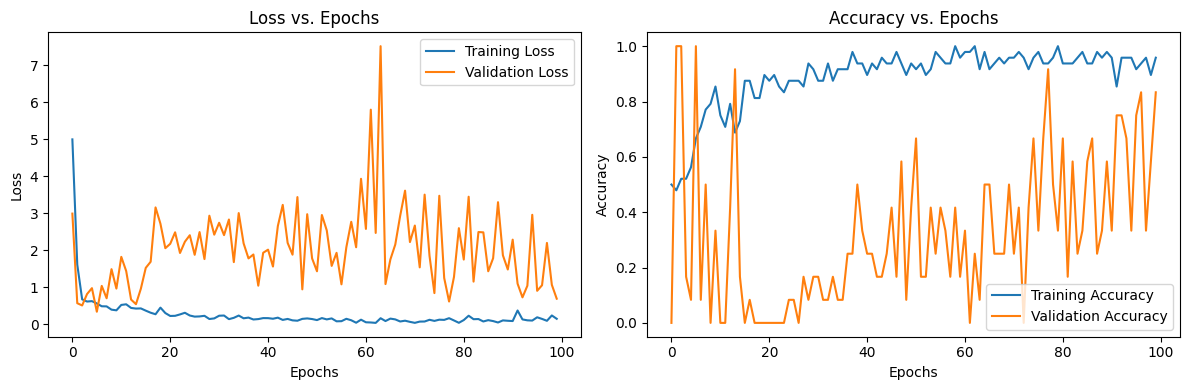

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Plot Loss and Accuracy throughout training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_loss, label='Training Loss')
ax1.plot(validation_loss, label='Validation Loss')
ax1.set_title('Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accuracy, label='Training Accuracy')
ax2.plot(validation_accuracy, label='Validation Accuracy')
ax2.set_title('Accuracy vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

I suspect that due to the limited sample size of our data (only 60 images is not much), there are trends in the images that correlate to the healthy vs sick image samples that are unrelated to the sick features of the trees. For example, visually inspecting the data shows that many of the healthy tree images contain the sky, and none of the sick images do. The healthy tree images also happen to be on average more exposed than sick images. The model is likely picking up on these features instead of the features that we want to capture.

### Visualization

To visualize how well our model is performing, we can simply chart actual classification vs. predicted classification.

In [ ]:
predict_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=clean_data
)

predict_generator = train_datagen.flow_from_dataframe(
    dataframe=brute_force_df,
    x_col='file_name',
    y_col='classification',
    target_size=(default_width, default_height),
    batch_size=1,
    class_mode='categorical'
)

results = pd.DataFrame(model.predict(predict_generator))
brute_force_df["predicted_sick_confidence"] = results[1]

def parse_sick_confidence(sick_confidence_percent):
    if sick_confidence_percent >= 0.5:
        return "sick"
    else:
        return "healthy"

brute_force_df["predicted_classification"] = brute_force_df["predicted_sick_confidence"].map(parse_sick_confidence)


Found 60 validated image filenames belonging to 2 classes.
60/60 [==============================] - 13s 220ms/step


In [ ]:
predictions_df = brute_force_df[['file_name', 'classification', 'predicted_classification', 'predicted_sick_confidence']]
predictions_df

,file_name,classification,predicted_classification,predicted_sick_confidence
0,data/trees/DJI_0025.JPG,healthy,sick,8.703704e-01
1,data/trees/DJI_0026.JPG,healthy,healthy,2.278061e-05
2,data/trees/DJI_0027.JPG,healthy,healthy,3.932372e-01
3,data/trees/DJI_0028.JPG,healthy,healthy,4.189202e-07
4,data/trees/DJI_0029.JPG,healthy,sick,7.696619e-01
5,data/trees/DJI_0030.JPG,healthy,healthy,1.467886e-01
6,data/trees/DJI_0031.JPG,healthy,healthy,7.829723e-02
7,data/trees/DJI_0032.JPG,healthy,healthy,1.559210e-02
8,data/trees/DJI_0055.JPG,healthy,sick,6.314053e-01
9,data/trees/DJI_0063.JPG,healthy,sick,7.668802e-01


If we list out each image, its classification, and the predicted classification, we note that the accuracy of our model is not nearly as high as our metrics report. We'll need to rewrite the functions for our metrics in order to accurately train our model and also accurately report its performance.

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# Everything below here is still in-progress


### Implementation 2: Localization Approach

So, for our next implementation of this model, we will be combining classification and localization techniques. In addition to classifying the image into healthy or sick as seen above, we will also be predicting the bounding box containing the sick tree features. For our visualization technique, we will use OpenCV to draw the bounding box onto the images.

The architecture of 



Fusion layer= combine two neural networks


In [ ]:
# Load only images that we are interested in for this model
localization_df = img_df[img_df['classification'].isin(['sick', 'healthy'])]

In [ ]:
# Prepare meta-parameters for model
default_width, default_height = 224, 224
default_size = (default_width, default_height)

# Define Data Cleaning step for Model
def clean_data(input_img, resize_width=default_width, resize_height=default_height):
    clean_img = input_img
    
    # Apply Data Cleaning Functions
    clean_img = resize_img(clean_img, resize_width, resize_height)
    
    output_img = clean_img
    return output_img

In [ ]:
# # We will need to create a custom data generator that properly handles the multiple inputs
# class AnnotatedImageDataGenerator(ImageDataGenerator):
#     pass

In [ ]:
# Define Data Augmentation step for model
# Apply a number of random transformations on data set to increase the model's accuracy on more general data.
# Chosen transformations: rotations, width-shift, height-shift, shear, zoom, horizontal flips
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=clean_data
)

In [ ]:
# # Define a new loss function, combining both the classification and localization loss functions

# def combined_loss(y_true, y_pred):
#     # Calculate classification loss
#     class_true = y_true[:, :-4]
#     class_pred = y_pred[:, :-4]
#     class_loss = tf.keras.losses.categorical_crossentropy(class_true, class_pred)

#     # Calculate bounding box loss
#     bbox_true = y_true[:, -4:]
#     bbox_pred = y_pred[:, -4:]
#     bbox_loss = tf.keras.losses.mean_squared_error(bbox_true, bbox_pred)

#     # Combine and return the losses
#     return class_loss + bbox_loss

In [ ]:
# Use tensorflow's Data Generator to create training and validation sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=localization_df,
    x_col='file_name',
    y_col=['x','y','width','height'],
    target_size=(default_width, default_height),
    batch_size=32,
    class_mode='multi_output',
    subset='training'
)
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=localization_df,
    x_col='file_name',
    y_col=['x','y','width','height'],
    target_size=(default_width, default_height),
    batch_size=32,
    class_mode='multi_output',
    shuffle=False,
    subset='validation'
)

# Build model with chosen layers
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='linear')
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Found 48 validated image filenames.
Found 12 validated image filenames.
Epoch 1/10
2/2 [==============================] - 6s 3s/step - loss: 1410968.0000 - val_loss: 2643.7588
Epoch 2/10
2/2 [==============================] - 5s 2s/step - loss: 1296420.6250 - val_loss: 55643.6875
Epoch 3/10
2/2 [==============================] - 5s 2s/step - loss: 1087592.8750 - val_loss: 566107.9375
Epoch 4/10
2/2 [==============================] - 5s 2s/step - loss: 1007691.6875 - val_loss: 660615.0000
Epoch 5/10
2/2 [==============================] - 5s 2s/step - loss: 1037487.3125 - val_loss: 326240.2812
Epoch 6/10
2/2 [==============================] - 5s 3s/step - loss: 991341.1875 - val_loss: 162904.5781
Epoch 7/10
2/2 [==============================] - 5s 3s/step - loss: 1018206.5625 - val_loss: 135710.3750
Epoch 8/10
2/2 [==============================] - 5s 3s/step - loss: 1013275.9375 - val_loss: 199623.8281
Epoch 9/10
2/2 [==============================] - 5s 3s/step - loss: 957678.4375 - v

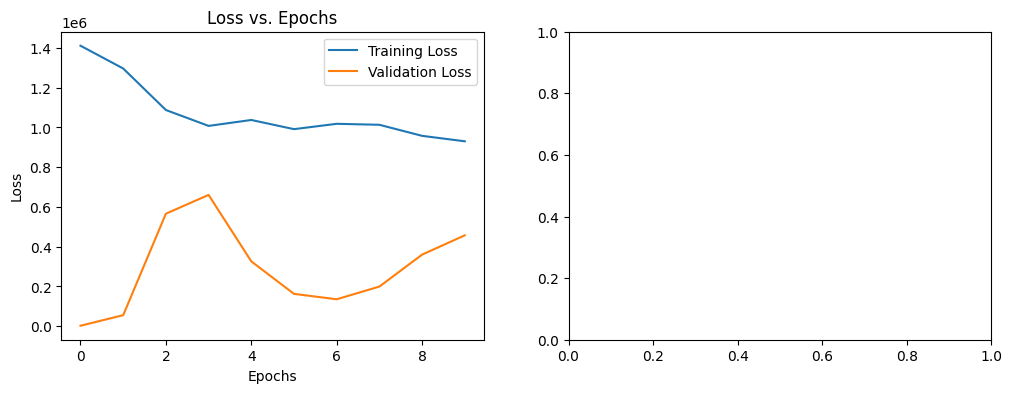

In [ ]:
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot Loss and Accuracy throughout training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_loss, label='Training Loss')
ax1.plot(validation_loss, label='Validation Loss')
ax1.set_title('Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

plt.show()

In [ ]:
# When scaling images down, we need to reframe the bounding boxes in terms of their new size

In [ ]:
model.predict(validation_generator)

1/1 [==============================] - 1s 744ms/step


array([[568.94403, 563.1502 , 539.9917 , 570.6648 ],
       [638.1359 , 630.6326 , 604.44293, 639.01025],
       [560.33966, 553.53253, 529.943  , 560.8508 ],
       [596.75836, 590.25397, 565.7075 , 598.08875],
       [954.56354, 944.8881 , 903.97235, 957.09644],
       [551.9164 , 546.4429 , 523.9332 , 553.5973 ],
       [627.2828 , 619.56866, 593.65326, 627.7821 ],
       [691.3804 , 683.1861 , 654.8291 , 692.191  ],
       [722.5093 , 713.85675, 683.6461 , 723.32825],
       [747.4249 , 738.30347, 706.81506, 748.10706],
       [747.18115, 737.9627 , 705.9098 , 747.88245],
       [678.4441 , 669.993  , 641.5148 , 678.84393]], dtype=float32)

In [ ]:
# Use some annotation library to draw the predicted bounding boxes on the images being tested